
# **Weighted SubSpace Search VQE**
####**Authors:** **Jay Patel, Siddarth Patel, Amit Hirpara**
---

Generally, The variational quantum eigensolver (VQE) is used for finding the ground state energy for a given hamiltonian. To find the ${k}^{th}$ excited state energy of for the hamiltonian we would need to run the VQE optimization process for atleast ${k+1}$ time. Not to mention each time we need to calculate the hamiltonian again taking into account the state of the previous iteration. Even after that the accuracy decreases as value of ${k}$ increases.

This is where the idea of ***Subspace Search VQE (SSVQE)*** comes in. The algorithm is used to find ${k}^{th}$ excited state energy of a hamiltonian in just two subsequent optimization processes. The original research about the development of SSVQE is given in this [paper](https://arxiv.org/pdf/1810.09434.pdf). But, can we do better? Yes, the research shows that using the weights as hyperparameters we can find the ${k}^{th}$ excited state energy in just single optimization process. This is a more generalised version of SSVQE namely, Weighted SSVQE and it will be the center of our focus in this project. There are two variants of this algorithm:

1) Weighted SSVQE to find ${k}^{th}$ excited state energy.

2) Weighted SSVQE to find all energies upto ${k}^{th}$ excited state.

> **Note:** We will be implementing this algorithm on ${n}$-qubit quntum computer. Hence the value of ${k}$ upto which we can perform the calculations will be ${k}\le{2}^{n}-1$.

Firstly, let's install the dependencies which we would need during this demo.

In [1]:
! pip install pennylane
! pip install pennylane-qchem

  Obtaining dependency information for pennylane from https://files.pythonhosted.org/packages/a3/2f/b741bad7ee00979280d64f438977f4dccc22215d81f637191eda9c6c1569/PennyLane-0.33.1-py3-none-any.whl.metadata
  Obtaining dependency information for rustworkx from https://files.pythonhosted.org/packages/87/1a/38643fd8b1e6daad3edc5392ec872901b6e3666bbd860dad259d09379e69/rustworkx-0.13.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for autograd from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for autoray>=0.6.1 from https://files.pythonhosted.org/packages/ad/93/c274651e4b9994edf77ab0af094c858c6a949c372f8d459920b1818f570e/autoray-0.6.7-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools from https://files.pythonhosted.org/packages/a2/91/2d843adb9fbd911e0da45fbf6f18ca89d07a087c3daa23e955584f90ebf4/cachetools-5.3

  error: subprocess-exited-with-error
  
  pip subprocess to install backend dependencies did not run successfully.
  exit code: 1
  
  [243 lines of output]
       ---------------------------------------- 0.0/7.3 MB ? eta -:--:--
       ---------------------------------------- 0.0/7.3 MB 991.0 kB/s eta 0:00:08
        --------------------------------------- 0.1/7.3 MB 980.4 kB/s eta 0:00:08
       - -------------------------------------- 0.2/7.3 MB 1.6 MB/s eta 0:00:05
       -- ------------------------------------- 0.5/7.3 MB 2.4 MB/s eta 0:00:03
       --- ------------------------------------ 0.7/7.3 MB 2.9 MB/s eta 0:00:03
       ----- ---------------------------------- 0.9/7.3 MB 3.1 MB/s eta 0:00:03
       ----- ---------------------------------- 1.0/7.3 MB 3.3 MB/s eta 0:00:02
       ----- ---------------------------------- 1.0/7.3 MB 3.3 MB/s eta 0:00:02
       ----- ---------------------------------- 1.0/7.3 MB 3.3 MB/s eta 0:00:02
       ----- --------------------------------

You may need to restart the kernal or runtime after performing above step. After that import the requirements for this demo.

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# **Weighted SSVQE to find ${k}^{th}$ excited state energy:**

This algorithm proposes a method to find one but any excited state energy using single optimization process.

### **Algorithm:**
* Construct an ansatz circuit ${U}(\theta)$ and choose states $\{\left|\varphi_{j}\right>\}_{j=0}^{k}$ which are orthogonal with each other ($⟨\varphi_{i}|\varphi_{j}\rangle = δ_{ij}$).
* Minimize $𝓛_{w}(\theta) = {w}⟨\varphi_{k}|U^†(\theta)HU(\theta)|\varphi_{k}\rangle + ∑_{j=0}^{k-1} ⟨\varphi_{j}|U^†(\theta)HU(\theta)|\varphi_{j}\rangle$, where the weight ${w}$ can be any value in $(0,1)$.

Here, $𝓛_{w}(\theta)$ is our cost function. The above algorithm is implemented via Pennylane code below. Below function is a callable which can be used to abstractly calculate the ${k}^{th}$ excited state energy.

In [3]:
def WEIGHTED_SSVQE(hamiltonian, ansatz, params, opt_name='Adam', stepsize=0.1, iterations=100, k=0, device_name='default.qubit'):
    """Calculates the kth excited state energy for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).
    Returns:
        => (Energy, Energies): The function returns a tuple of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)

    #Define the weights for the cost function.
    weights = np.random.random()

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)
    
    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
        if index == k:
          cost += weights * state_cost(params, state_value=index)
        else:
          cost += state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = []
    
    # Optimization loop.
    for _ in range(iterations):
      params = optimizer.step(total_cost, params)
      energy = state_cost(params, state_value=k)
      energies.append(energy)
    return energies[-1], energies

# **Weighted SSVQE to find all energies up to ${k}^{th}$ excited state:**

This algorithm proposes a method to find all excited state energy upto ${k}^{th}$  excited state using single optimization process.

### **Algorithm:**
* Construct an ansatz circuit ${U}(\theta)$ and choose states $\{\left|\varphi_{j}\right>\}_{j=0}^{k}$ which are orthogonal with each other ($⟨\varphi_{i}|\varphi_{j}\rangle = δ_{ij}$).
* Minimize $𝓛_{w}(\theta) = ∑_{j=0}^{k} {w_{j}}⟨\varphi_{j}|U^†(\theta)HU(\theta)|\varphi_{j}\rangle$, where the weight vector ${w}$ is chosen such that ${w_{i}}>{w_{j}}$ when ${i}<{j}$.

Here, $𝓛_{w}(\theta)$ is our cost function. The above algorithm is implemented below. The algorithm provides a large utility value. However, it takes more time to execute than the former varient due to the larger span of subspace. 

In [4]:
def WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, params, opt_name='Adam', stepsize=0.1, iterations=100, k=[0], device_name='default.qubit'):
    """Calculates the energies upto Kth excited state for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K till which the excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of List of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)

    #Define the weights for the cost function.
    weights = np.arange(k+1, 0, -1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(k+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((k+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(k+1):
        energy = state_cost(params, state_value=index)
        energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

# **Can we do even better?**
The above first algorithm can give us only one excited state energy at a time. although second one gives us a large spectra, what if we don't need all of them? Even if you filter the output the function will regardlessly calculate the all energies up to ${k}^{th}$ excited state. So, if we need the excited state energies of the set $\{1,3,4\}$ and if we pass $k = 4$ to above function it will also run the algorithm for the values $0$ and $2$. This increases the runtime.

After carefully observing the properties of both the algorithms we decided to optimize the **Weighted SSVQE All** algorithm so that it can accept a set of values of ${k}$ and can return the energy outputs for only those particluar values of ${k}$. This algorithm if used in this way has more use in practice than the other ones. The algorithm uses same step as mentioned in the algorithm of **Weighted SSVQE All** but it only calculates and stores the value of energies for ${k}\in{K}$. where ${K}$ is the set of input values of $k$. This reduces the computation time depending on the length of ${K}$.

The implementation is given below as a function. It will give us the excited state energies of the required states in the ascending order values of ${k}$ in the set ${K}$.


In [5]:
def WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, params, opt_name='Adam', stepsize=0.1, iterations=100, k=[0], device_name='default.qubit'):
    """Calculates the kth excited state energy from the list of values of k for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (List(int)): List of K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of list of Energy of Kth excited state and list of energies at each iteration for plotting the graph. 
           The list will be in the sorted order of elements in the list k.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)

    #Define the weights for the cost function.
    weights = np.arange(max(k)+1,0,-1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
      state_prep(state_value)
      ansatz(params, wires)
      return qml.expval(hamiltonian)
    
    # Total cost of the system.
    def total_cost(params):
      cost = 0
      for index in range(max(k)+1):
          cost += weights[index] * state_cost(params, state_value=index)
      return cost

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((max(k)+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params = optimizer.step(total_cost, params)
      for index in range(max(k)+1):
        if index in k:
          energy = state_cost(params, state_value=index)
          energies[index][itr] = energy

    # Return List
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

# **Advantages of Weighted SSVQEs:**
* Optimization process runs only once for whole algorithm to work.
* Unlike VQE, There is no need to calculate the hamiltonian after each step.
* Swap test is not involved because orthogonality of the states will be insured regardlessly.
* The results of the algorithms are unique regardless of the values of hyperparameters given that they meet certain conditions.
* Using The **Weighted SSVQE Custom** We can skip the unnecessary calculations and get the benefit of both **Weighted SSVQE** and **Weighted SSVQE All** at will. 


# **Examples:**
We will be implementing the above functions for few hamiltonians for testing. For simplicity purposes we will be considering the ansatz given in the below cell for our examples. It will work just fine for our use-case and will hold accuratly for first few values of ${k}$. It allows us to control the number of layers hence can be adjusted to our needs. Take a note that large values of k we may need to carefully prepare ansatz so that the resulting energies converge to exact values. We will be taking parameters for our ansatz as uniformly distributed random angles $\theta\in[0,2π)$.

In [6]:
#Circuit Anstaz:
def ansatz(params, wires):
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

## **Hydrogen Molecule (${H}_2$):**


In [7]:
# Molecule Parameters:
symbols_h2 = ["H", "H"]
geometry_h2 = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

# Hamiltonian:
hamiltonian_h2, qubits_h2 =  qml.qchem.molecular_hamiltonian(
        symbols_h2,
        geometry_h2,
        active_electrons=2,
        active_orbitals=2
)

# Params:
params_h2 = np.random.uniform(0, 2*np.pi, (6, qubits_h2, 3))

#### **Finding energies:**

In [8]:
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian_h2, ansatz, params_h2, stepsize=0.05, k=0)
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian_h2, ansatz, params_h2, stepsize=0.05, k=1)

# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian_h2, ansatz, params_h2, stepsize=0.05, k=1)

# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian_h2, ansatz, params_h2, stepsize=0.05, k=[0])

#### **Outputs:**

In [9]:
# Output:
print('Weighted SSVQE:')
print('Energy of Ground state for the H2 hamiltonian is:', energy_G_1)
print('Energy of First Excited state for the H2 hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of Ground state for the H2 hamiltonian is:', energies_all[0][0])
print('Energy of First Excited state for the H2 hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of Ground state for the H2 hamiltonian is:', energies_custom[0][0])

Weighted SSVQE:
Energy of Ground state for the H2 hamiltonian is: -1.1361650421202938
Energy of First Excited state for the H2 hamiltonian is: -0.5125942671014994

Weighted SSVQE All:
Energy of Ground state for the H2 hamiltonian is: -1.13558921772119
Energy of First Excited state for the H2 hamiltonian is: -0.517687287604474

Weighted SSVQE Custom:
Energy of Ground state for the H2 hamiltonian is: -1.1361650416934723


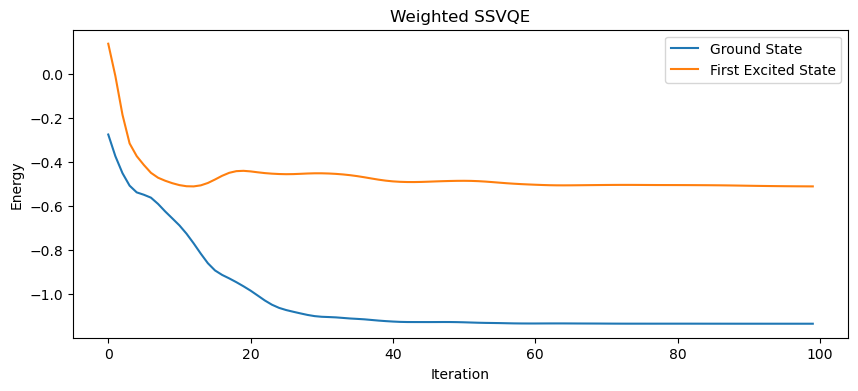

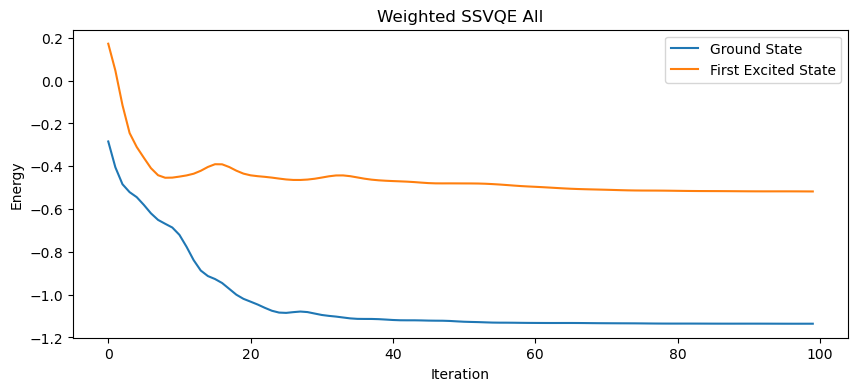

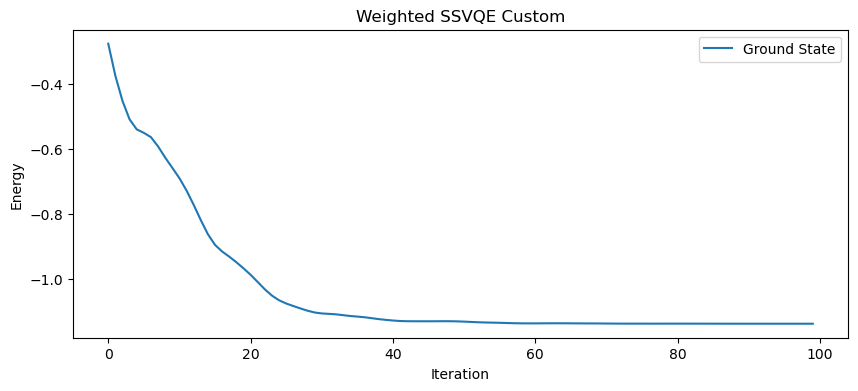

In [10]:
# Graph plot:
Iterations = [*range(0, 100)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='Ground State')
plt.plot(Iterations, energies_1_1, label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='Ground State')
plt.plot(Iterations, energies_all[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='Ground State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

# **Lithium Hydride Molecule (${LiH}$):**

In [11]:
# Molecule Parameters:
symbols_lih = ["Li", "H"]
geometry_lih = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.969280527])

# Hamiltonian:
hamiltonian_lih, qubits_lih =  qml.qchem.molecular_hamiltonian(
        symbols_lih,
        geometry_lih,
        active_electrons=2,
        active_orbitals=2
)

# Params:
params_lih = np.random.uniform(0, 2*np.pi, (6, qubits_lih, 3))

#### **Finding energies:**

In [12]:
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=0)
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=1)

# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=1)

# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=[1])

#### **Output:**

In [13]:
# Output:
print('Weighted SSVQE:')
print('Energy of Ground state for the LiH hamiltonian is:', energy_G_1)
print('Energy of First Excited state for the H2 hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of Ground state for the LiH hamiltonian is:', energies_all[0][0])
print('Energy of First Excited state for the LiH hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of First Excited state for the LiH hamiltonian is:', energies_custom[1][0])

Weighted SSVQE:
Energy of Ground state for the LiH hamiltonian is: -7.862909221049924
Energy of First Excited state for the H2 hamiltonian is: -7.779621011108546

Weighted SSVQE All:
Energy of Ground state for the LiH hamiltonian is: -7.862391755524643
Energy of First Excited state for the LiH hamiltonian is: -7.7758177630269065

Weighted SSVQE Custom:
Energy of First Excited state for the LiH hamiltonian is: -7.7758177630269065


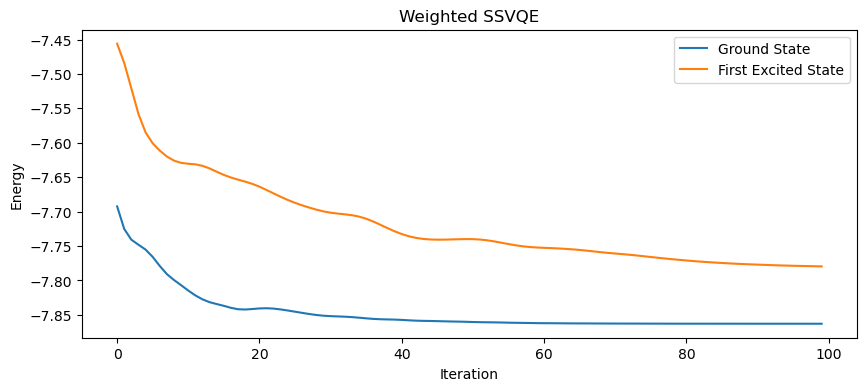

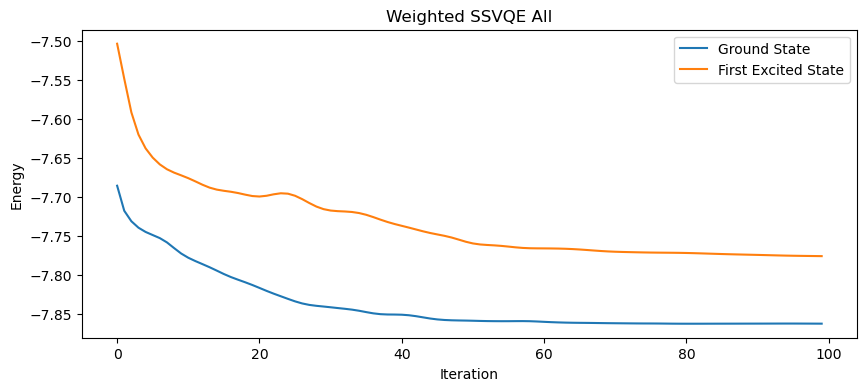

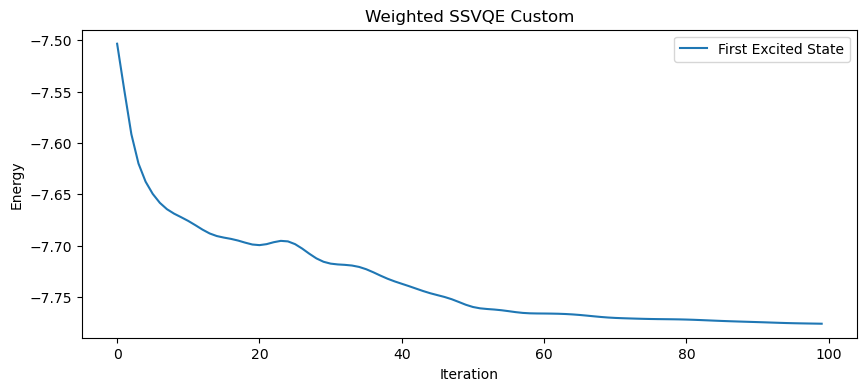

In [14]:
# Graph plot:
Iterations = [*range(0, 100)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='Ground State')
plt.plot(Iterations, energies_1_1, label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='Ground State')
plt.plot(Iterations, energies_all[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

# **FluoroMethane ($CH_3F$):**

In [15]:
# Molecule Parameters:
symbols_ch3f = ["C", "H", "H", "H", "F"]
geometry_ch3f = np.array([-0.6783, 0.0, 0.0, -1.0293, 0.464, 0.9239, -1.0293, 0.5681, -0.8639, -1.0293, -1.0322, -0.0601, 0.6783, 0.0, 0.0])

# Hamiltonian:
hamiltonian_ch3f, qubits_ch3f =  qml.qchem.molecular_hamiltonian(
        symbols_ch3f,
        geometry_ch3f,
        active_electrons=2,
        active_orbitals=2
)

# Params:
params_ch3f = np.random.uniform(0, 2*np.pi, (6, qubits_ch3f, 3))

#### **Finding Energies:**

In [16]:
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian_ch3f, ansatz, params_ch3f, stepsize=0.05, k=0)
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian_ch3f, ansatz, params_ch3f, stepsize=0.05, k=1)

# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian_ch3f, ansatz, params_ch3f, stepsize=0.05, k=1)

# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian_ch3f, ansatz, params_ch3f, stepsize=0.05, k=[0,1,2,5])

#### **Output:**

In [17]:
# Output:
print('Weighted SSVQE:')
print('Energy of Ground state for the CH3F hamiltonian is:', energy_G_1)
print('Energy of First Excited state for the H2 hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of Ground state for the CH3F hamiltonian is:', energies_all[0][0])
print('Energy of First Excited state for the CH3F hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of Ground state for the CH3F hamiltonian is:', energies_custom[0][0])
print('Energy of First Excited state for the CH3F hamiltonian is:', energies_custom[1][0])
print('Energy of Second Excited state for the CH3F hamiltonian is:', energies_custom[2][0])
print('Energy of Fifth Excited state for the CH3F hamiltonian is:', energies_custom[5][0])

Weighted SSVQE:
Energy of Ground state for the CH3F hamiltonian is: -132.77029060964585
Energy of First Excited state for the H2 hamiltonian is: -132.35482440741075

Weighted SSVQE All:
Energy of Ground state for the CH3F hamiltonian is: -132.76960157858164
Energy of First Excited state for the CH3F hamiltonian is: -132.35394340530794

Weighted SSVQE Custom:
Energy of Ground state for the CH3F hamiltonian is: -132.7702872010914
Energy of First Excited state for the CH3F hamiltonian is: -132.3554077117843
Energy of Second Excited state for the CH3F hamiltonian is: -132.3553876636256
Energy of Fifth Excited state for the CH3F hamiltonian is: -131.68026196833193


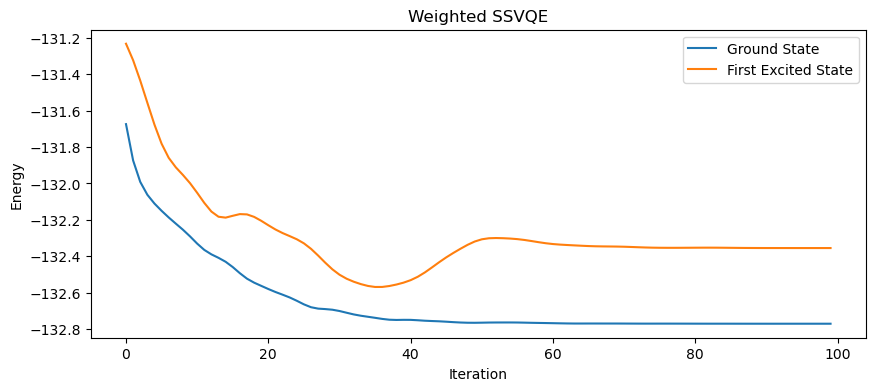

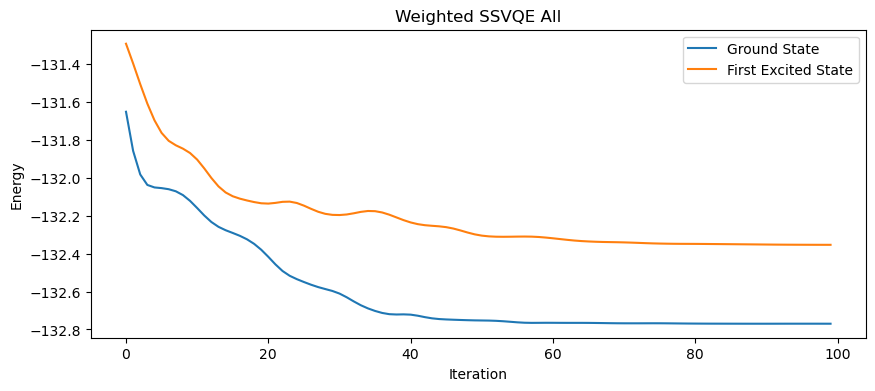

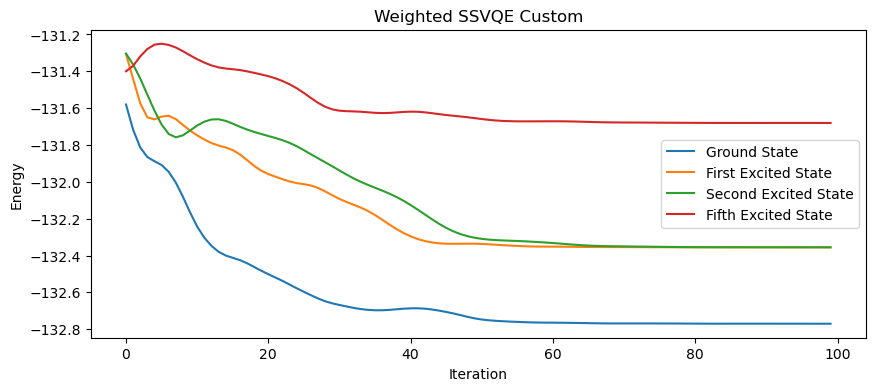

In [18]:
# Graph plot:
Iterations = [*range(0, 100)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='Ground State')
plt.plot(Iterations, energies_1_1, label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='Ground State')
plt.plot(Iterations, energies_all[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations, energies_custom[0][1], label='Ground State')
plt.plot(Iterations, energies_custom[1][1], label='First Excited State')
plt.plot(Iterations, energies_custom[2][1], label='Second Excited State')
plt.plot(Iterations, energies_custom[5][1], label='Fifth Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

# **Observations:**
* Ansatz needs to be prepared carefully and it's properties depends of what kind of hamiltonians are we using and it also depends on how big the value of ${k}$ we want to keep.
* The values converges near to its exact values when ${k}$ is smaller. Our ansatz fulfils its purpose for relatively small value of ${k}$.
* Runtime of each algorithm is noticed between $20s$ to $1 min$ depending on the values of ${k}$. considering the span of Subspace and the outputs it provides, this much time does not seem long.
* If you carefully try to observe you will see a peculiar simularity with grover's algorithm. Not exactly but in amplitude amplification, by using repeated steps we try to emplify the probability, Here, we do similar thing but using weights and optimization.
* The weights multiplied to the state we want acts like minimizing factor, if the value of weigths is between $[0,1)$ then the overall cost of that state decreases and hence to balance it out, it gets picked more no. of times. This is just an analogy to understand the relation. 

# **References:**
* https://arxiv.org/pdf/1810.09434.pdf
* https://pubchem.ncbi.nlm.nih.gov/